# Spatial statistics

Spatial statistics are widely used in geography, geology, environmental science, sociology, urban planning, epidemiology and economics. We have previously participated in an effort to provide a spatial statistics guide for spatial transcriptomics that explains the basic concepts and methods and is also applicable to spatial proteomics data: [pasta spatial statistics guide](https://robinsonlabuzh.github.io/pasta/00-home.html)

`spatiomic` also provides a set of functions to calculate spatial statistics, too. In this notebook, we will show how to use these methods on spatial proteomics data. `spatiomic` builds on top of `esda` and `pysal`, which can also be used for further analysis as `spatiomic.spatial.spatial_weights` returns a `pysal` `W` object.

In [1]:
import esda
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from colorcet import coolwarm
from matplotlib.colors import ListedColormap
from skimage.filters import threshold_otsu
from skimage.transform import downscale_local_mean

import spatiomic as so

## Data loading

In [2]:
image_id = "245 g1"

In [3]:
# read the image and convert the dimension order to XYC/channel-last
img_data = so.data.read().read_tiff(
    f"./data/mouse_cgn/{image_id}.tif",
    input_dimension_order="CYX",
)
img_data = downscale_local_mean(img_data, (4, 4, 1))

# load the clustered image
clustered_img = np.load(f"./data/mouse_cgn/{image_id}-labelled.npy")

# load the channel list
channels = list(pd.read_csv("./data/mouse_cgn/channel_names.csv", header=0).T.to_numpy()[0])

img_data.shape, clustered_img.shape

((438, 438, 35), (438, 438))

## Calculate spatial weights

In [4]:
neighborhood_offset = so.spatial.neighborhood_offset(
    neighborhood_type="queen",
    order=2,
    exclude_inner_order=1,
)

Create a `pysal` weights object for your image based on the neighborhood offset.

In [5]:
spatial_weights = so.spatial.spatial_weights(
    data_shape=img_data.shape[:2],
    neighborhood_offset=neighborhood_offset,
)

Creating spatial weights for each offset: 100%|██████████| 16/16 [00:00<00:00, 1520.19it/s]


Let's visualize the spatial weights matrix for an example point.

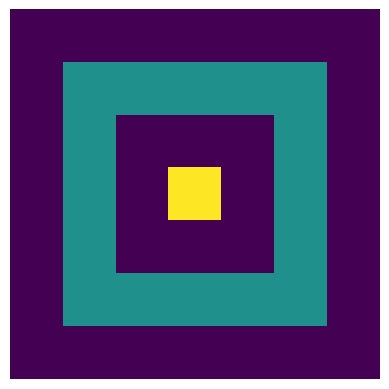

In [6]:
image = np.zeros_like(clustered_img).flatten()
point_idx = 16000
image[
    spatial_weights.to_adjlist(drop_islands=True)[spatial_weights.to_adjlist(drop_islands=True).focal == point_idx][
        "neighbor"
    ].to_numpy()
] = 1
image[point_idx] = 2
image = image.reshape(clustered_img.shape)

plt.imshow(image[33:40, 229:236])
plt.gca().set_axis_off()

## Calculate the autocorrelation

In [7]:
correlation = so.spatial.autocorrelation().predict(
    data=clustered_img,
    spatial_weights=spatial_weights,
)

Calculating spatial autocorrelation for each channel/cluster: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


<Axes: title={'center': "Moran's I for each cluster"}, xlabel='cluster'>

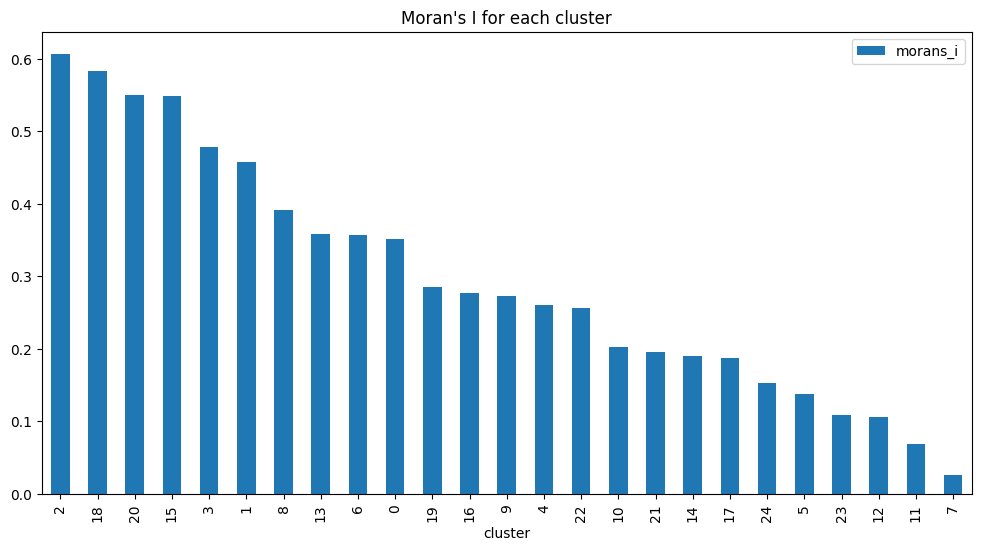

In [8]:
correlation.sort_values("morans_i", ascending=False).plot.bar(
    x="cluster",
    y="morans_i",
    figsize=(12, 6),
    title="Moran's I for each cluster",
)

## Local statistics

Let's take a look at OAT1, a marker of the proximale tubule, especially the brush border.

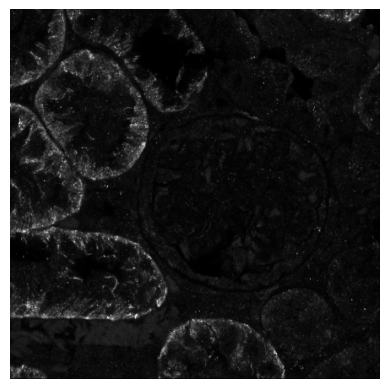

In [9]:
plt.imshow(img_data[:, :, channels.index("OAT1")], cmap="gray")
plt.gca().set_axis_off()

### Getis-Ord Gi*

Let's try to find local hotspots using Getis-Ord Gi*. For this, we will downscale the image to speed up the computation.

In [10]:
image_downscaled = downscale_local_mean(
    img_data[:, :, channels.index("OAT1") : channels.index("OAT1") + 1],
    (4, 4, 1),
)

In [11]:
spatial_weights_circle = so.spatial.spatial_weights(
    data_shape=image_downscaled.shape[:2],
    neighborhood_offset=so.spatial.neighborhood_offset(
        neighborhood_type="circle",
        order=10,
        exclude_inner_order=0,
    ),
)

Creating spatial weights for each offset: 100%|██████████| 316/316 [00:00<00:00, 20182.73it/s]


In [12]:
local_autocorrelation_gi = so.spatial.local_autocorrelation().predict(
    data=image_downscaled,
    spatial_weights=spatial_weights_circle,
    method="getisord",
    star=True,
)
local_autocorrelation_gi.columns

/var/folders/vg/vt1jjh256dn1g4sd6pknwxbs_qmnws/T/ipykernel_74345/1097534021.py:1: UserWarning: Data is not in float64 format. Converting to float64 required by `esda`.
  local_autocorrelation_gi = so.spatial.local_autocorrelation().predict(


Index(['local_statistic', 'z_score', 'p_value', 'expected_value'], dtype='object')

We can visualize the hotspots and through simple thresholding, we can get an approximate segmentation of the proximale tubule.

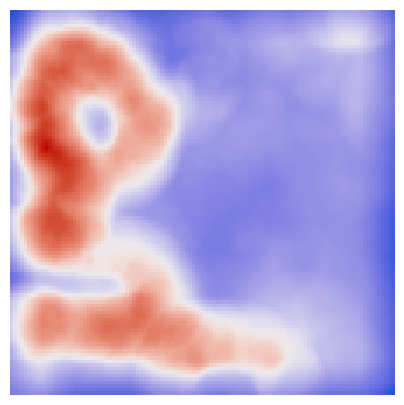

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(
    local_autocorrelation_gi["local_statistic"].to_numpy().reshape(image_downscaled.shape[:2]),
    cmap=ListedColormap(coolwarm),
)
ax.set_axis_off()

We can do the same with the local Moran's I.

In [14]:
local_autocorrelation_moran = so.spatial.local_autocorrelation().predict(
    data=image_downscaled,
    spatial_weights=spatial_weights_circle,
    method="moran",
    permutation_count=100,
)
local_autocorrelation_moran.columns

/var/folders/vg/vt1jjh256dn1g4sd6pknwxbs_qmnws/T/ipykernel_74345/1680012595.py:1: UserWarning: Data is not in float64 format. Converting to float64 required by `esda`.
  local_autocorrelation_moran = so.spatial.local_autocorrelation().predict(


Index(['local_statistic', 'quadrant', 'p_value', 'z_score', 'expected_value'], dtype='object')

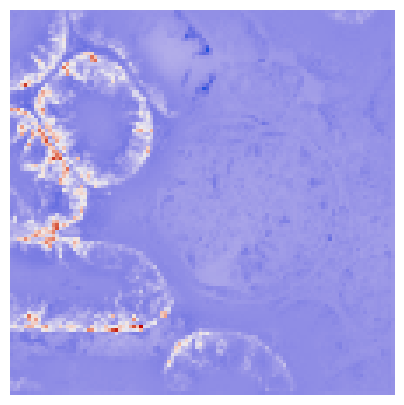

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(
    local_autocorrelation_moran["local_statistic"].to_numpy().reshape(image_downscaled.shape[:2]),
    cmap=ListedColormap(coolwarm),
)
ax.set_axis_off()

### Local Heteroskedasticity

LOSH can help us find regions were signals change fast, e.g., borders. Since this is sensitive to the intensity of the specific signal, let's look at nuclei and binarize our data.

In [16]:
nuclei_thresholded = (
    img_data[..., channels.index("DRAQ5") : channels.index("DRAQ5") + 1]
    > threshold_otsu(img_data[..., channels.index("DRAQ5") : channels.index("DRAQ5") + 1]) * 0.5
)

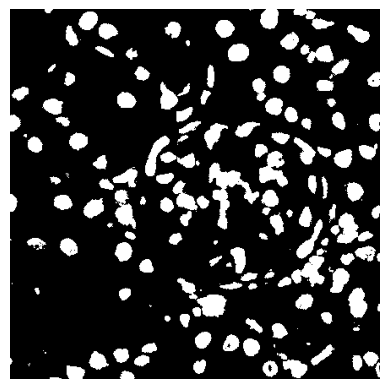

In [17]:
plt.imshow(nuclei_thresholded, cmap="gray")
plt.gca().set_axis_off()

We will use a queen neighborhood that does not reach far.

In [18]:
spatial_weights_losh = so.spatial.spatial_weights(
    data_shape=nuclei_thresholded.shape[:2],
    neighborhood_offset=so.spatial.neighborhood_offset(
        neighborhood_type="queen",
        order=1,
        exclude_inner_order=0,
    ),
)

Creating spatial weights for each offset: 100%|██████████| 8/8 [00:00<00:00, 1307.81it/s]


In [19]:
losh = so.spatial.local_heteroskedasticity().predict(
    data=nuclei_thresholded,
    channel_names=["DRAQ5"],
    spatial_weights=spatial_weights_losh,
)

Now we can visualize the border region.

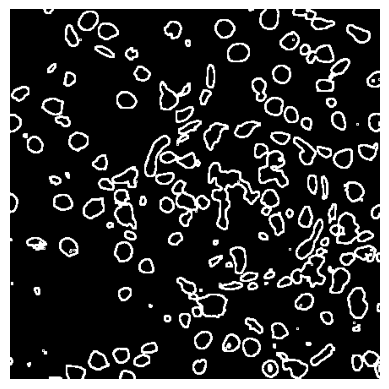

In [20]:
plt.imshow(
    losh.loc["DRAQ5"].losh.reshape(nuclei_thresholded.shape[:2]) > 4,
    cmap="gray",
)
plt.gca().set_axis_off()

## Join counts and vicinity graph

In [21]:
df_vicinity_composition, df_p_values = so.spatial.vicinity_composition(
    data=clustered_img,
    ignore_repeated=True,
    permutations=100,
)
df_vicinity_composition.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,731,96,180,393,131,178,94,435,206,...,233,25,46,63,237,184,121,68,176,62
1,522,0,996,789,3599,1031,829,69,149,250,...,263,82,39,199,144,151,111,18,628,31
2,94,1012,0,933,1545,207,191,234,33,19,...,29,48,69,58,98,31,103,27,425,37
3,214,792,937,0,1279,253,326,133,162,48,...,120,82,81,143,153,61,125,152,297,72
4,393,3704,1614,1243,0,324,164,233,338,49,...,130,54,28,260,227,81,327,25,1217,552


The association between cluster 9 and cluster 6 seems to be significant.

In [22]:
df_p_values.iloc[9, 6].round(4)

np.float64(0.0099)

In [23]:
vicinity_graph = so.spatial.vicinity_graph(
    data=df_vicinity_composition,
)

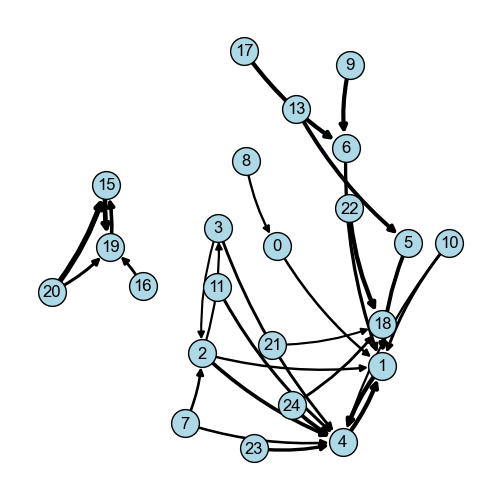

In [24]:
fig = so.plot.spatial_graph(
    vicinity_graph,
    edge_threshold=0.15,
)
fig.set_size_inches(5, 5)
fig.set_dpi(100)

## Interoperability with `esda`

Use `esda` to get the spatial bivariate statistics for combinations of immunofluorescence markers. We can use the same spatial weights object as before.

In [25]:
np.random.seed(3407)
moran_bv = esda.moran.Moran_BV(
    img_data[:, :, channels.index("cjun")],
    img_data[:, :, channels.index("Vimentin")],
    spatial_weights,
    transformation="r",
    permutations=100,
)
np.round(moran_bv.I, 4), np.round(moran_bv.p_sim, 4)

(np.float64(0.3642), np.float64(0.0099))

In [26]:
np.random.seed(3407)
lees_l_estimator = esda.lee.Spatial_Pearson(connectivity=spatial_weights.to_sparse(), permutations=100)
lees_l_estimator.fit(
    img_data[:, :, channels.index("cjun")].reshape(-1, 1),
    img_data[:, :, channels.index("Vimentin")].reshape(-1, 1),
)
np.round(lees_l_estimator.association_[0, 1], 4)

np.float64(0.3427)